# Working with IMU data

In this assignment, you will work with inertial navigation units (IMUs) including accelerameter, gyro and magnetometer. In the first part, you will implement the procedure to estimate poses from IMU data collected from a stationary device. In the second part, you will implement an algorithm to count steps from accelemeter data. Let us get started!

## 1. Package

Let's first import all the packages that you will need during this assignment.
- sys, numpy, scipy, matplotlib
- ianus for sensor data handling

In [1]:
import sys
import numpy as np
import ianus
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d 
from scipy.signal import butter, filtfilt, lfilter

## 1. Pose estimation 
In this part, you need to implement a function that takes the accelerometer and magnetometer readings and returns the rotation matrix in the global coordinate frame. Recall in the lecture, we introduce two coordinate systems: the global system and the device coordinate system as illustrated below. Note that we use "coordinate system" and "reference frame" interchangably. 
![Global and device coordinate systems](reference_frames.jpg)

Let $A = [acc_x, acc_y, acc_z]$ and $E = [mag_x, mag_y, mag_z]$ be the accelerometer and magnetometer readings (in the device frame). Then, the device pose (or the device frame) can be obtained by applying a rotation matrix $R$ computed as follows. 
- Step 1: $H = E \times A$
- Step 2: $A' = A/\sqrt{A\cdot A}$, $H' = H/\sqrt{H\cdot H}$.
- Step 3: $M = A' \times H'$
- Step 4: $R = [H', M, A']^T$. Here we assume all vectors are column vectors. 

In [2]:
def pose_estimate(A, E):
    """
    Estimate a stationary device's pose using accelerometer and magnetometer readings in the device frame
    Input:
        acc -- 3-D vector of acceleration along device x, y, z axis
        mag -- 3-D vector of magnetic field measurement along device x, y, z axis
    
    Output: 
        R -- 3 x 3 rotation matrix
    """
    # YOUR CODE
    H = np.cross(E,A)
    A_prime = A/np.sqrt(np.dot(A,A))
    H_prime = H/np.sqrt(np.dot(H,H))
    M = np.cross(A_prime,H_prime)
    R = np.array([H_prime.T,M.T,A_prime.T])
    
    return R

In [3]:
# test case 1
acc1 = np.array([-0.0771,   -0.2093,   10.0756])
mag1 = np.array([6.1156,  -28.8635,  -52.4388])

pose_estimate(acc1, mag1)

array([[-0.98222014, -0.18738578, -0.01140865],
       [ 0.18757681, -0.98206683, -0.01896507],
       [-0.00765028, -0.02076787,  0.99975505]])

**Expected Output**:

<table>
    <tr>
        <td> array([[-0.98222014, -0.18738578, -0.01140865],  </td>
        <td> [ 0.18757681, -0.98206683, -0.01896507], </td>
        <td> [-0.00765028, -0.02076787,  0.99975505]])</td>
    </tr>
</table>

In [4]:
# test case 2
acc2 = np.array([9.6692,    0.0063,   -0.5559])
mag2 = np.array([-54.1391,   23.2355,  -11.2771])

pose_estimate(acc2, mag2)

array([[ -4.84985880e-02,  -5.25311260e-01,  -8.49526907e-01],
       [ -3.07039101e-02,   8.50909899e-01,  -5.24413590e-01],
       [  9.98351219e-01,   6.50479117e-04,  -5.73970383e-02]])

**Expected Output**:

<table>
    <tr>
        <td> array([[ -4.84985880e-02,  -5.25311260e-01,  -8.49526907e-01], </td>
        <td> [ -3.07039101e-02,   8.50909899e-01,  -5.24413590e-01], </td>
        <td> [  9.98351219e-01,   6.50479117e-04,  -5.73970383e-02]])</td>
    </tr>
</table>

### 1.1 (Optional) Compute Z-Y-X Euler angles from rotation matrix

In [5]:
def Rot2EulerZYZ(R):
    if (R[2,0]!=1) and (R[2,0]!=-1):
        y1=np.arcsin(-R[2,0])
        y2=math.pi-y1
        x1=math.atan2(R[2,1]/math.cos(y1),R[2,2]/math.cos(y1))
        x2=math.atan2(R[2,1]/math.cos(y2),R[2,2]/math.cos(y2))
        z1=math.atan2(R[1,0]/math.cos(y1),R[0,0]/math.cos(y1))
        z2=math.atan2(R[1,0]/math.cos(y2),R[0,0]/math.cos(y2))
        angle1=[z1,y1,x1]
        angle2=[z2,y2,x2]
        print('Z-Y-X Euler angles:',angle1, 'or',angle2)
    else:
        y1=math.pi/2
        angle1=['NaN',math.pi/2,'NaN']
        angle2=angle1
        print('Angle of Y axis:', y1, '\nAngles of X axis and Z axis cannot be determined.')
    return angle1,angle2

R=np.matrix('0 -1 0; 1 0 0; 0 0 1')
#R=np.matrix('0 0 1; 0 1 0; -1 0 0')
#R=np.matrix('0 0 1; 0 -1 0; -1 0 0')
Rot2EulerZYZ(R)

Z-Y-X Euler angles: [1.5707963267948966, 0.0, 0.0] or [-1.5707963267948966, 3.1415926535897931, -3.141592653589793]


([1.5707963267948966, 0.0, 0.0],
 [-1.5707963267948966, 3.1415926535897931, -3.141592653589793])

## 2. Step counting

In this part, we will detect step events and count the number of steps using accelerometer data. Recall in the lecture that step detection is done via peak detection of low-pass filtered accelerometer magnitude data. 

### 2.1 Read sensor data and ground truth data ###
- X_raw is accelerometer data num_of_samples x 4. Each row contains [timestamp in ms, acc_x, acc_y, acc_z]
- Y is a 1-d array of timestamps (ms) when step events occur. 

In [6]:
datapath = '/Users/rzheng/Teach/CAS772fa17/exercises/hw2/dataset/' #changed to an absolute path to the dataset directory 

#X_raw is N x 4 matrix where N is # of samples, the columns are respectively, [timestamp, acc_x, acc_y, acc_z] 
X_raw = np.array(ianus.reader.read_imu_data(datapath+'accelerometer.pbf')['acc'])
#print('shape of X_raw',X_raw.shape)

#Y is a 1-D array that contains the timestamps of step events
Y = np.array(ianus.reader.read_marker_data(datapath+'step_event.pbf'))[:,0]
#print('shape of Y', Y.size)

min_ts = min(X_raw[:,0])
X_raw[:,0] = (X_raw[:,0] - min_ts)/1e6 #change to ms 
Y = (Y - min_ts)/1e6 #change to ms 
#print(Y)

fs = 100 # (re)sampling frequency in Hz
fc_hpf = 0.1 # cut-off frequency for high pass filter for linear acceleration in Hz
fc_lpf = 3 # cut-off frequency for low pass friter for acc magnitude in Hz

### 2.2 Visualize the raw accelerometer data

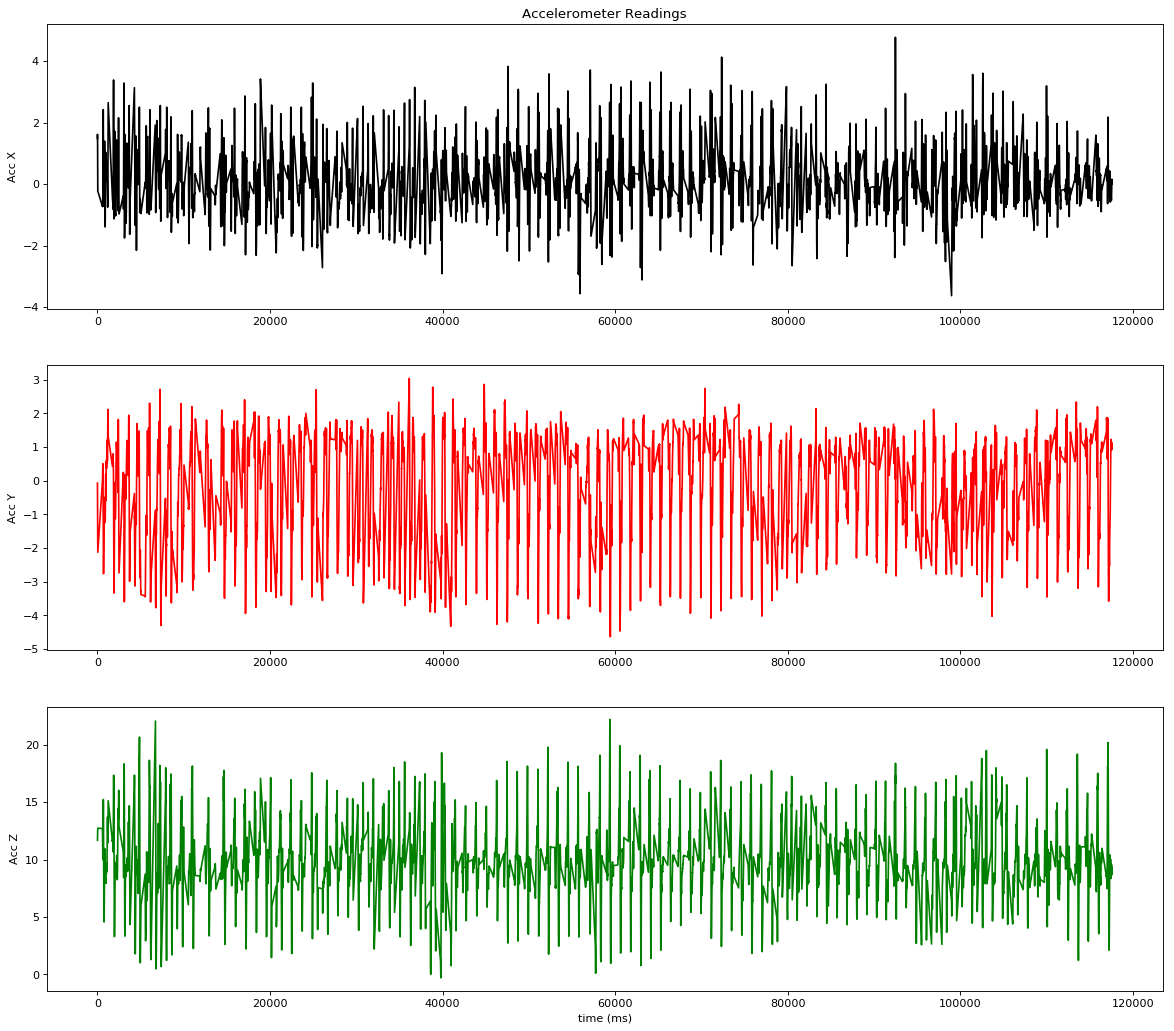

In [7]:
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(X_raw[:,0], X_raw[:,1], 'k-')
plt.title('Accelerometer Readings')
plt.ylabel('Acc X')

plt.subplot(3, 1, 2)
plt.plot(X_raw[:,0], X_raw[:,2], 'r-')
plt.ylabel('Acc Y')

plt.subplot(3, 1, 3)
plt.plot(X_raw[:,0], X_raw[:,3], 'g-')
plt.ylabel('Acc Z')
plt.xlabel('time (ms)')

plt.show()

### 2.3 Pre-process accelerometer data
The raw data is not suitable for step event detection for two reasons. First, since data is collected via the Android sensor API, the samples *may not* be obtained at fixed intervals. This implies digital filters cannot be applied directly. Second, the raw acceleration contains a gravity component and shall be removed. Since we do not know the device pose to directly subtract the gravity component, we can apply a simple exponential moving average filter (EMA) and *substract* it from the original signal for **each component**. This is equivalent to applying a high pass filter. 
- Step 1. Interpolate the accelerometer data to be evenly sampled at fs
- Step 2. Compute linear acceleration. You can use a cut-off frequency fc_hpf

#### 2.3.1 Visualize unevent sensing intervals of acceleration data. 

As you can see from the CDF plot below, even though majority of the interval is around 9ms, some are as big as 548 and some as small as 2ms. 

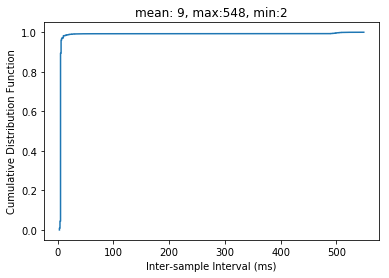

In [8]:
ti = np.sort(X_raw[1:-1,0] - X_raw[0:-2,0])
#print('size of X_raw[1:-1,0]:',X_raw[1:-1,0].size)
#print('size of ti', ti.size)
#print('ti',ti)

plt.plot(ti, np.linspace(0,1,ti.size)) #Returns num evenly spaced samples, calculated over the interval [start, stop].
mytitle = 'mean: %d, max:%d, min:%d'%(np.mean(ti), np.max(ti), np.min(ti))
plt.title(mytitle)
plt.xlabel('Inter-sample Interval (ms)')
plt.ylabel('Cumulative Distribution Function')
plt.show()

#### 2.3.2 Interpolate the data to f_s = 100Hz

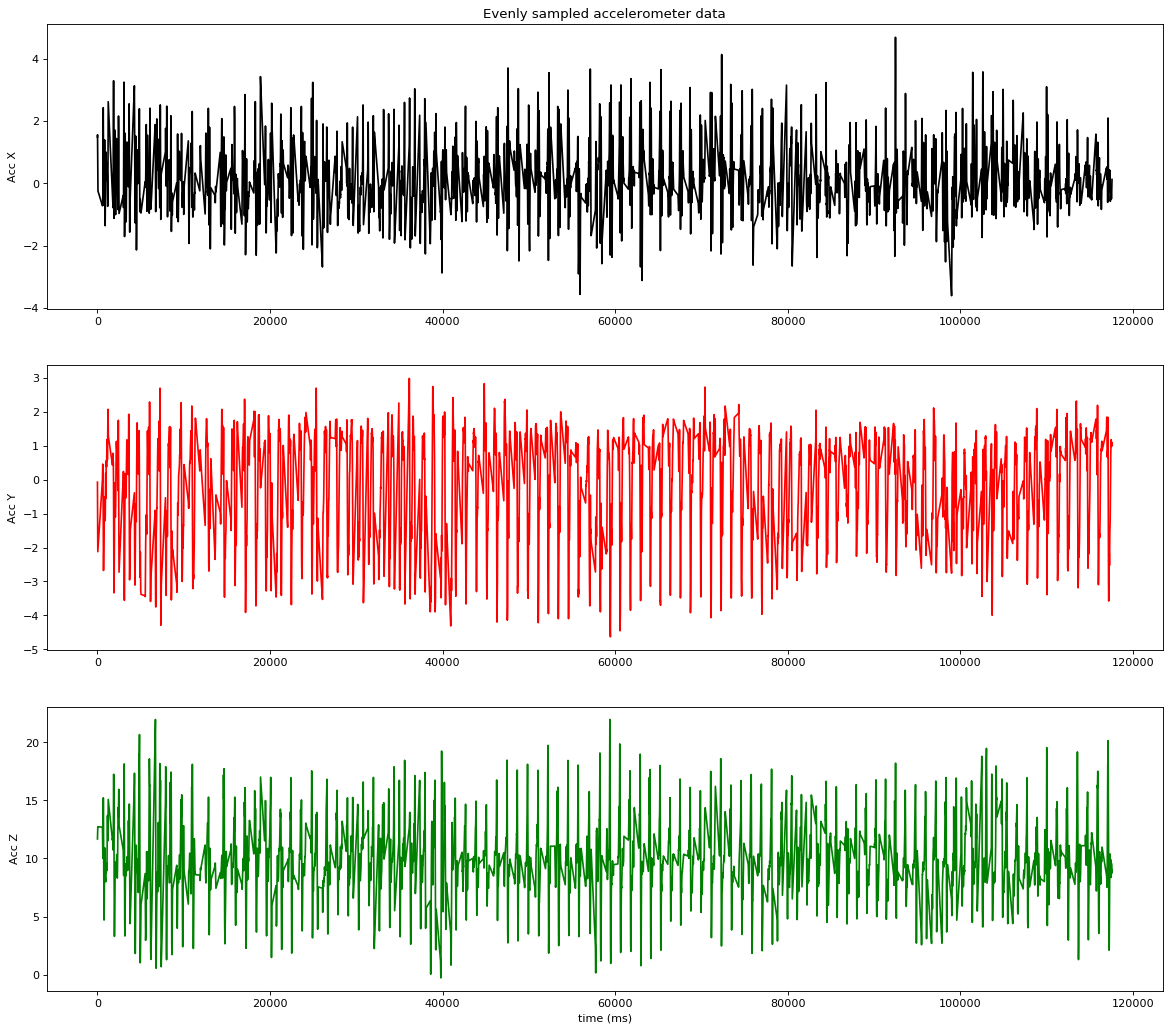

In [9]:
ts = np.arange(np.amin(X_raw[:,0]), np.max(X_raw[:,0]), step=1000/fs)
#print('ts',ts)
#print(np.amin(X_raw[:,0]))

#YOUR CODE 3 - 4 lines. 'linear' interpolation is recommendated
f1 = interp1d(X_raw[:,0],X_raw[:,1])
f2 = interp1d(X_raw[:,0],X_raw[:,2])
f3 = interp1d(X_raw[:,0],X_raw[:,3])
Xi = f1(ts)
Yi = f2(ts)
Zi = f3(ts)

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3, 1, 1)
plt.plot(ts, f1(ts), 'k-')
plt.title('Evenly sampled accelerometer data')
plt.ylabel('Acc X')

plt.subplot(3, 1, 2)
plt.plot(ts, f2(ts), 'r-')
plt.ylabel('Acc Y')

plt.subplot(3, 1, 3)
plt.plot(ts, f3(ts), 'g-')
plt.ylabel('Acc Z')
plt.xlabel('time (ms)')

plt.show()

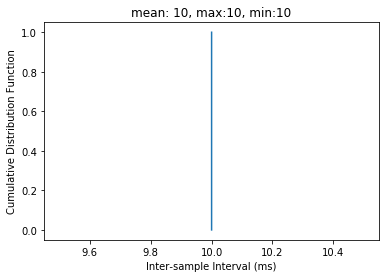

In [10]:
#Test even sensing intervals of acceleration data
tstest = np.sort(ts[1:-1] - ts[0:-2])
plt.plot(tstest, np.linspace(0,1,tstest.size)) #Returns num evenly spaced samples, calculated over the interval [start, stop].
mytitle = 'mean: %d, max:%d, min:%d'%(np.mean(tstest), np.max(tstest), np.min(tstest))
plt.title(mytitle)
plt.xlabel('Inter-sample Interval (ms)')
plt.ylabel('Cumulative Distribution Function')
plt.show()

### 2.4 Compute magnitude and visualize

- Step 1: Compute linear acceleration. Suggested cut-off for tge high pass filter is fc_hpf
- Step 2: Compute the magitude
- Step 3: Visualize the magnitue

In [11]:
def emwfilter(x, a, axis=0):
    """The exponential moving average filter y(n) = (1-a)*x(n)+a*y(n-1)
    INPUT: 
        x -- input time series
        a -- weight
    OUTPUT: 
        y -- filter data
    """
    y = lfilter([1-a], [1, -a], x, axis)
    
    # remove the artifacts at the beginning
    #scale = 1 - np.power(a, np.linspace(1, x.shape[0]+1, x.shape[0])).reshape(x.shape[0],1)
    
    #return y/scale
    return y

In [12]:
# compute the coefficient
a_emw = np.exp(-2*np.pi*fc_hpf/fs)
#print(a_emw)

# Step 1: YOUR CODE
Xe = Xi - emwfilter(Xi, a_emw, axis=0)
Ye = Yi - emwfilter(Yi, a_emw, axis=0)
Ze = Zi - emwfilter(Zi, a_emw, axis=0)

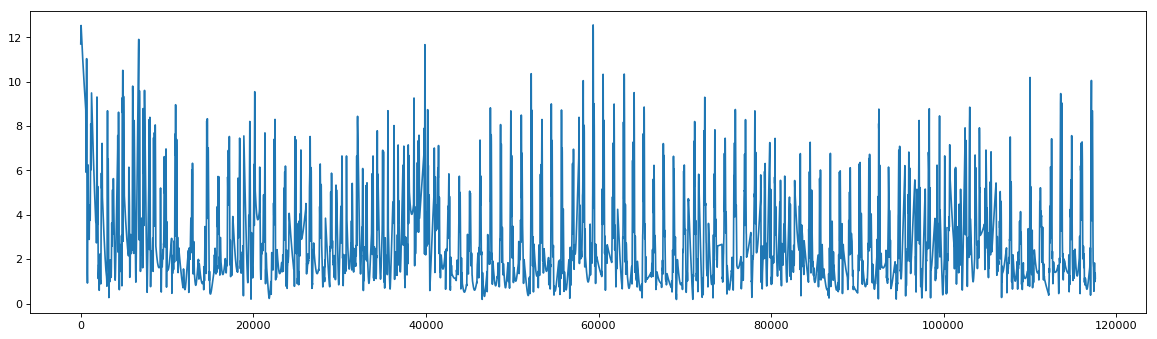

In [13]:
# Step 2, 3: YOUR CODE
acce = np.sqrt(Xe**2+Ye**2+Ze**2)
plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ts,acce)
plt.show()

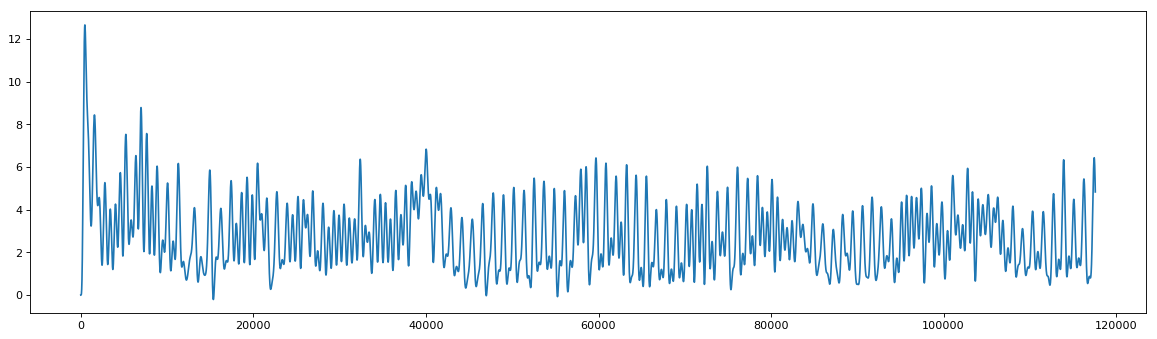

In [14]:
def butter_lfilter(data, fc, fs, order=5, fb = False):
    """
    Butterworth digital low-pass filter
    Inputs:
        - data: input
        - fc: cutoff freq (Hz)
        - fs: sampling freq (Hz)
        - order: order of the filter (default to 5)
        - fb: forward and backward filter to compensate for the phase shift (default to False)
    Output:
        - filtered data
    """
    nyq = 0.5 * fs
    low = fc / nyq
    b, a = butter(order, low, btype='low')
    if fb:
        y = filtfilt(b, a, data)
    else: 
        y = lfilter(b, a, data)
    
    return y

fc_lpf = 2
accb = butter_lfilter(acce, fc_lpf, fs, 5, True)
plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(ts,butter_lfilter(accb, fc_lpf, fs))
#plt.plot(ts, Zb)
plt.show()

### 2.6 Peak finding

Tip: You can use peakutils from https://bitbucket.org/lucashnegri/peakutils
You can install the package by running in command line:

git clone https://bitbucket.org/lucashnegri/peakutils.git

**Note: you need to restart the kernel in jupyter each time a new package is installed for it to be effective**

In [15]:
# To help you evaluate, we provide the following function to evaluate the performance

def eval_perf(ground_truth, detected_event):
    """
    STEP COUNTING EVALUATION
    INPUTS:
        ground_truth -  1-D array of the timestamps of step events from the ground truth data (in ms)
        detected_event -  1-D array of the timestamps of step events from the algorithm (in ms)
    OUPUTS:
        TP - true positive
        FP - false positive
        FN - false negative
        Precision - TP/(TP+FP)
        Recall - TP/(TP+FN)
    """

    STEP_WINDOW = 600 #ms assume one step lasts 600ms
    step_counts = np.zeros((ground_truth.shape[0], 1))
    alt_step_counts = np.zeros((detected_event.shape[0], 1))


    for step in range(ground_truth.shape[0]):
        step_counts[step] = np.count_nonzero((detected_event < ground_truth[step] + STEP_WINDOW/2) & 
                                             (detected_event >= ground_truth[step] - STEP_WINDOW/2))
         
    for step in range(detected_event.shape[0]):
        alt_step_counts[step] = np.count_nonzero((ground_truth < detected_event[step] + STEP_WINDOW/2) & 
                                                 (ground_truth >= detected_event[step] - STEP_WINDOW/2))
    
    #get TP, TN etc, calc precison and recall
    TP = np.count_nonzero(step_counts>0)
    FP = np.count_nonzero(alt_step_counts == 0)
    FN = np.count_nonzero(step_counts == 0)
    Precision = TP/(TP + FP)
    Recall = TP/(TP + FN)
    F1 = 2*Precision*Recall/(Recall+Precision)
    print('-------Reports--------------------------\n')
    print('Number of events: %d\n'% ground_truth.shape[0])
    print('Number of detected events: %d\n'% detected_event.shape[0])
    print('True Positive: %d\n'% TP)
    print('False Positive: %d\n'% FP)
    print('False Negative: %d\n'% FN)
    print('Precision: %6.4f\n'% Precision)
    print('Recall: %6.4f\n'% Recall)
    print('F1 score: %6.4f\n'% F1)
    print('-------END------------------------------\n')

In [ ]:
import peakutils
from peakutils.plot import plot as pplot
# YOUR CODE (use peakutils.peak.indexes(y, thres=??, min_dist=??), tune the parameters
indexes = peakutils.indexes(accb, thres=0.34, min_dist=25)
#print(indexes)
#print(x[indexes], y[indexes])
plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
pplot(ts, accb, indexes)
plt.title('First estimate')
plt.show()

<font color="red">RZ: I was puzzled why your baseline results are so bad and realized that you should call instead</font>
    eval_perf(Y, ts[indexes])


In [ ]:
eval_perf(Y, indexes)

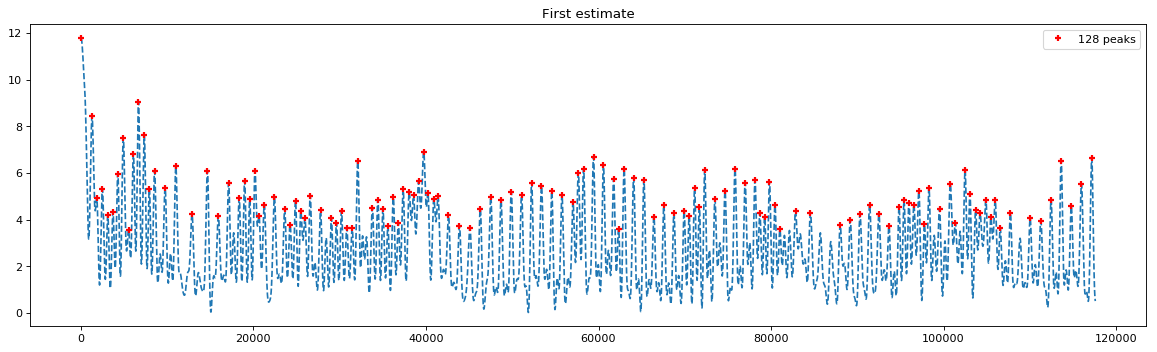

-------Reports--------------------------

Number of events: 100

Number of detected events: 128

True Positive: 94

False Positive: 34

False Negative: 6

Precision: 0.7344

Recall: 0.9400

F1 score: 0.8246

-------END------------------------------

-------Reports--------------------------

Number of events: 100

Number of detected events: 128

True Positive: 94

False Positive: 34

False Negative: 6

Precision: 0.7344

Recall: 0.9400

F1 score: 0.8246

-------END------------------------------



/Users/rzheng/Development/anaconda3/lib/python3.6/site-packages/PeakUtils-1.1.0-py3.6.egg/peakutils/peak.py:221: UserWarning: At least 3 points required for Gaussian fitting


In [18]:
peaks_x = peakutils.interpolate(ts, accb, ind=indexes, width=10)
#second indexes
#print(peaks_x)

#plt.figure(figsize=(10,6))
#pplot(ts, acc, peaks_x)
#plt.title('Second estimate')
#plt.show()
eval_perf(Y, peaks_x)

## Report and Submission : 
- Evaluate the effects of the cut-off frequencies of low pass and high pass filters on the step counting performance. Explain the empirical results. Can you suggest any way to automatically tune the cut-off frequencies? 
- Evaluate the effects of parameter settings in the **peakutils.indexes** function. Explain the empirical results. 
- Include your ipynb code and your report in a directory under the gitlab project folder you previously shared with the instructor.